### Scripts of monthly aggregate

#### Script for making mean yearly wind direction and speed TIF files w/o aggregation

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from pathlib import Path

def calculate_aggregations_and_save_tif(input_nc_file, pressure_level=1000, min_year=None, max_year=None, year_interval=None):
    """
    Calculate wind speed and direction averages at a specified pressure level, and save the results into new GeoTIFF files.
    
    Parameters:
    input_nc_file (str): Path to NetCDF file with wind data.
    pressure_level (int): Pressure level to analyze (default is 1000 mb).
    min_year (int): Optional, minimum year for analysis.
    max_year (int): Optional, maximum year for analysis.
    year_interval (int): Optional, number of years for grouping (e.g., 5 for 5-year intervals, 10 for 10-year intervals). 
                         If None, aggregate over the full available year range.
    
    Output:
    GeoTIFF files containing aggregated results for wind speed and wind direction, named based on the time period.
    """

    # Load the dataset
    ds = xr.open_dataset(input_nc_file, engine='netcdf4')

    # Ensure the 'date' coordinate is in the correct format
    if not np.issubdtype(ds['date'].dtype, np.datetime64):
        ds['date'] = pd.to_datetime(ds['date'].values, format='%Y%m%d')

    # Check if the specified pressure level exists in the dataset
    if 'pressure_level' in ds.coords and pressure_level in ds['pressure_level'].values:
        # Select the specified pressure level
        ds = ds.sel(pressure_level=pressure_level)
    else:
        raise ValueError(f"Pressure level {pressure_level} mb not found in the dataset.")

    # Check if 'u' and 'v' components exist in the dataset
    if 'u' not in ds or 'v' not in ds:
        raise KeyError(f"The dataset does not contain the required 'u' and 'v' wind components.")

    # Calculate wind speed (m/s) from u and v components
    ds['wind_speed'] = np.sqrt(ds['u']**2 + ds['v']**2)

    # Calculate wind direction in degrees, following meteorological convention (0° = North)
    ds['wind_dir'] = (270 - np.rad2deg(np.arctan2(ds['v'], ds['u']))) % 360

    # Determine the available years in the dataset
    years = ds['date'].dt.year.values
    available_min_year = years.min()
    available_max_year = years.max()

    # Set default min_year and max_year if not provided
    start_year = min_year if min_year else available_min_year
    end_year = max_year if max_year else available_max_year

    # Check for conflicts in year range
    if start_year > end_year:
        raise ValueError(f"min_year ({start_year}) cannot be greater than max_year ({end_year}).")
    
    if start_year < available_min_year or end_year > available_max_year:
        raise ValueError(f"The selected year range ({start_year}-{end_year}) is outside the available data range ({available_min_year}-{available_max_year}).")

    # Check if year_interval is larger than the available range
    if year_interval and year_interval > (end_year - start_year + 1):
        print(f"Year interval ({year_interval}) is larger than the available year range ({start_year}-{end_year}). Processing the entire range as a single block.")
        year_interval = None  # Set to None to process as a single block

    input_nc_path = Path(input_nc_file)
    output_dir = input_nc_path.parent  # Output in the same directory as the input
    base_output_file_name = f"{input_nc_path.stem}_{pressure_level}mb"

    # Handle year intervals
    if year_interval is None:
        # Aggregate over the full available year range
        data_interval = ds.sel(date=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
        interval_mean = data_interval.mean(dim='date', skipna=True)  # Handle NaN values
        output_file = output_dir / f"{base_output_file_name}_{start_year}_{end_year}"
        process_aggregation_and_save_as_tif(interval_mean, output_file)
    else:
        # Subdivide into year intervals and process each group
        process_by_year_interval(ds, start_year, end_year, year_interval, output_dir, base_output_file_name)

def process_by_year_interval(ds, start_year, end_year, year_interval, output_dir, base_output_file_name):
    """
    Process data in blocks based on the specified year interval.
    """
    for year_start in range(start_year, end_year + 1, year_interval):
        year_end = min(year_start + year_interval - 1, end_year)
        year_label = f"{year_start}_{year_end}"
        
        # Select the data within the year range
        data_interval = ds.sel(date=slice(f"{year_start}-01-01", f"{year_end}-12-31"))

        # Check if the selected dataset is empty
        if data_interval.date.size == 0:
            print(f"No data available for the interval {year_label}. Skipping...")
            continue
        
        # Aggregate over the time dimension within the interval
        interval_mean = data_interval.mean(dim='date', skipna=True)

        # Generate output file name and save as GeoTIFF
        output_file = output_dir / f"{base_output_file_name}_{year_label}"
        process_aggregation_and_save_as_tif(interval_mean, output_file)

def calculate_average_wind_direction_using_uv(aggregated):
    mean_u = aggregated['u'].mean(dim='date', skipna=True)
    mean_v = aggregated['v'].mean(dim='date', skipna=True)
    
    avg_direction = (270 - np.degrees(np.arctan2(mean_v, mean_u))) % 360
    
    return avg_direction

def process_aggregation_and_save_as_tif(aggregated, output_file):
    """
    Process aggregated wind speed and direction, then save as GeoTIFF files using rasterio.
    
    Parameters:
    aggregated (xarray.Dataset): Aggregated dataset (e.g., for a year interval or full range).
    output_file (Path): Output file name without extension.
    """

    # Extract necessary data
    avg_wind_speed = aggregated['wind_speed'].squeeze().values  # Ensure it is 2D (lat, lon)
    avg_wind_dir = aggregated['wind_dir'].squeeze().values  # Ensure it is 2D (lat, lon)
    latitudes = aggregated['latitude'].values
    longitudes = aggregated['longitude'].values

    # Check if the dataset is valid and has the correct shape
    if avg_wind_speed.ndim != 2 or avg_wind_speed.size == 0:
        print(f"Invalid dataset for {output_file}. Skipping...")
        return

    # Define the raster transformation (assuming regular grid with constant spacing)
    transform = from_origin(np.min(longitudes), np.max(latitudes), np.abs(longitudes[1] - longitudes[0]), np.abs(latitudes[1] - latitudes[0]))

    # Define metadata for GeoTIFF files
    meta = {
        'driver': 'GTiff',
        'height': avg_wind_speed.shape[0],  # Number of latitudes
        'width': avg_wind_speed.shape[1],   # Number of longitudes
        'count': 1,                         # Single band (wind speed or direction)
        'dtype': 'float32',
        'crs': 'EPSG:4326',                 # Coordinate reference system (WGS84)
        'transform': transform
    }

    # Save the wind speed raster
    wind_speed_tif = f"{output_file}_wind_speed.tif"
    with rasterio.open(wind_speed_tif, 'w', **meta) as dst:
        dst.write(avg_wind_speed, 1)  # Writing the aggregated wind speed

    print(f"Wind speed GeoTIFF saved to {wind_speed_tif}")

    # Save the wind direction raster
    wind_dir_tif = f"{output_file}_wind_dir.tif"
    with rasterio.open(wind_dir_tif, 'w', **meta) as dst:
        dst.write(avg_wind_dir, 1)  # Writing the averaged wind direction

    print(f"Wind direction GeoTIFF saved to {wind_dir_tif}")

# Example usage:
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0.nc"
calculate_aggregations_and_save_tif(input_nc_file, pressure_level=250, year_interval=10)

Processing data for 01-1970 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_1970_01 ...
Processing data for 01-1980 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_1980_01 ...
Processing data for 01-1990 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_1990_01 ...
Processing data for 01-2000 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_2000_01 ...
Processing data for 01-2010 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_2010_01 ...
Processing data for 01-2020 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_2020_01 ...


#### Script for making wind direction TIF files with aggregation

In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from pathlib import Path

def calculate_aggregations_and_save_tif(input_nc_file, aggregation="yearly", pressure_level=1000, min_year=None, max_year=None, year_interval=None, period=None, month_year=None):

    """
    This script processes ERA5 data to generate wind direction averages for yearly, seasonal, quarterly, or specific month-year periods.
    It allows the user to specify a range of years and intervals, and supports processing exact seasons (e.g., DJF for winter),
    quarters (e.g., Q1 for January-March), or a specific month-year (e.g., 01-1940 for January 1940 or multiple months/years).
    Output is saved as GeoTIFF files.

    Parameters:
    - input_nc_file: Path to the input NetCDF file containing wind data.
    - aggregation: Defines the type of aggregation (yearly, seasonal, quarterly, or month-year).
    - pressure_level: The pressure level to analyze (default is 1000 mb).
    - min_year, max_year: The start and end year for analysis.
    - year_interval: The interval of years to group data (e.g., 5-year blocks).
    - period: Defines the season (e.g., 'DJF') or quarter (e.g., 'Q1') for aggregation.
    - month_year: Specifies multiple month-year pairs to extract, passed as a list of two arrays (e.g., [[1, 2], [1940, 1950, 1960]]).

    Output:
    GeoTIFF files containing aggregated wind direction data for the specified periods and intervals.
    """

    ds = xr.open_dataset(input_nc_file, engine='netcdf4')

    date_var = 'date' if 'date' in ds else 'valid_time' if 'valid_time' in ds else None
    if not date_var or not np.issubdtype(ds[date_var].dtype, np.datetime64):
        raise KeyError("No valid date variable found or incorrect format")

    ds[date_var] = pd.to_datetime(ds[date_var].values, format='%Y%m%d')
    ds = ds.sel(pressure_level=pressure_level) if 'pressure_level' in ds.coords and pressure_level in ds['pressure_level'].values else ds
    if 'u' not in ds or 'v' not in ds:
        raise KeyError("Dataset lacks 'u' and 'v' components")

    years = ds[date_var].dt.year.values
    start_year = min_year if min_year else years.min()
    end_year = max_year if max_year else years.max()

    if start_year > end_year or start_year < years.min() or end_year > years.max():
        raise ValueError("Invalid year range")

    input_nc_path = Path(input_nc_file)
    output_dir = input_nc_path.parent
    base_output_file_name = f"{input_nc_path.stem}_{pressure_level}mb"

    periods = {'DJF': ([12, 1, 2], 'winter'), 'MAM': ([3, 4, 5], 'spring'), 'JJA': ([6, 7, 8], 'summer'), 'SON': ([9, 10, 11], 'fall'),
               'Q1': ([1, 2, 3], 'Q1'), 'Q2': ([4, 5, 6], 'Q2'), 'Q3': ([7, 8, 9], 'Q3'), 'Q4': ([10, 11, 12], 'Q4')}

    if period and period not in periods:
        raise ValueError(f"Invalid period '{period}'")

    if aggregation == "month-year" and not month_year:
        raise ValueError("For 'month-year' aggregation, 'month_year' parameter must be provided")

    def process_month_year_aggregation(ds, month_year, output_dir, base_output_file_name, date_var):
        months, years = month_year
        for year in years:
            for month in months:
                data_interval = ds.sel({date_var: slice(f"{year}-{month:02d}-01", f"{year}-{month:02d}-31")})
                monthly_mean_u = data_interval['u'].mean(dim=date_var, skipna=True)
                monthly_mean_v = data_interval['v'].mean(dim=date_var, skipna=True)
                monthly_mean = xr.Dataset({'u': monthly_mean_u, 'v': monthly_mean_v})
                output_file = output_dir / f"{base_output_file_name}_{year}_{month:02d}"
                print(f"Processing {output_file} for {year}-{month:02d}")
                process_aggregation_and_save_as_tif(monthly_mean, output_file)

    def process_yearly_aggregation(ds, start_year, end_year, output_dir, base_output_file_name, date_var):
        data_interval = ds.sel({date_var: slice(f"{start_year}-01-01", f"{end_year}-12-31")})
        yearly_mean_u = data_interval['u'].mean(dim=date_var, skipna=True)
        yearly_mean_v = data_interval['v'].mean(dim=date_var, skipna=True)
        yearly_mean = xr.Dataset({'u': yearly_mean_u, 'v': yearly_mean_v})
        output_file = output_dir / f"{base_output_file_name}_{start_year}_{end_year}_yearly"
        print(f"Processing {output_file} for {start_year}-{end_year}")
        process_aggregation_and_save_as_tif(yearly_mean, output_file)

    def process_period_aggregation(ds, start_year, end_year, periods, output_dir, base_output_file_name, period, date_var):
        months, label = periods[period]
        data_interval = ds.sel({date_var: slice(f"{start_year}-01-01", f"{end_year}-12-31")})
        period_data_u = data_interval.sel({date_var: data_interval[date_var].dt.month.isin(months)})['u'].mean(dim=date_var, skipna=True)
        period_data_v = data_interval.sel({date_var: data_interval[date_var].dt.month.isin(months)})['v'].mean(dim=date_var, skipna=True)
        period_data = xr.Dataset({'u': period_data_u, 'v': period_data_v})
        if period_data['u'].size == 0 or period_data['v'].size == 0:
            raise ValueError(f"No valid data found for {label} in {start_year}-{end_year}")
        output_file = output_dir / f"{base_output_file_name}_{start_year}_{end_year}_{label}"
        print(f"Processing {output_file} for {start_year}-{end_year} ({label})")
        process_aggregation_and_save_as_tif(period_data, output_file)

    def process_aggregation_and_save_as_tif(aggregated, output_file):
        avg_u = aggregated['u'].values
        avg_v = aggregated['v'].values
        avg_wind_dir = (180 + np.rad2deg(np.arctan2(avg_v, avg_u))) % 360
        latitudes = aggregated['u']['latitude'].values
        longitudes = aggregated['u']['longitude'].values
        if avg_wind_dir.ndim != 2 or avg_wind_dir.size == 0:
            raise ValueError(f"Invalid dataset for {output_file}")
        transform = from_origin(np.min(longitudes), np.max(latitudes), np.abs(longitudes[1] - longitudes[0]), np.abs(latitudes[1] - latitudes[0]))
        meta = {'driver': 'GTiff', 'height': avg_wind_dir.shape[0], 'width': avg_wind_dir.shape[1], 'count': 1, 'dtype': 'float32', 'crs': 'EPSG:4326', 'transform': transform}
        with rasterio.open(f"{output_file}_wind_dir.tif", 'w', **meta) as dst:
            dst.write(avg_wind_dir, 1)

    if aggregation == "month-year":
        process_month_year_aggregation(ds, month_year, output_dir, base_output_file_name, date_var)
    elif year_interval is None:
        if aggregation == "yearly":
            process_yearly_aggregation(ds, start_year, end_year, output_dir, base_output_file_name, date_var)
        elif aggregation in ["seasonal", "quarterly"]:
            process_period_aggregation(ds, start_year, end_year, periods, output_dir, base_output_file_name, period, date_var)
    else:
        for year_start in range(start_year, end_year + 1, year_interval):
            year_end = min(year_start + year_interval - 1, end_year)
            if aggregation == "yearly":
                process_yearly_aggregation(ds, year_start, year_end, output_dir, base_output_file_name, date_var)
            elif aggregation in ["seasonal", "quarterly"]:
                process_period_aggregation(ds, year_start, year_end, periods, output_dir, base_output_file_name, period, date_var)

# Example usage:
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_2.nc"
calculate_aggregations_and_save_tif(input_nc_file, aggregation="month-year", month_year=[[1], [1970, 1980, 1990, 2000, 2010, 2020]])


Processing D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_2_1000mb_1970_01 for 1970-01
Processing D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_2_1000mb_1980_01 for 1980-01
Processing D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_2_1000mb_1990_01 for 1990-01
Processing D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_2_1000mb_2000_01 for 2000-01
Processing D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_2_1000mb_2010_01 for 2010-01
Processing D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_2_1000mb_2020_01 for 2020-01


#### Script for temporal windrose chart after extracting pixel counts using a quadrants of the bounding box

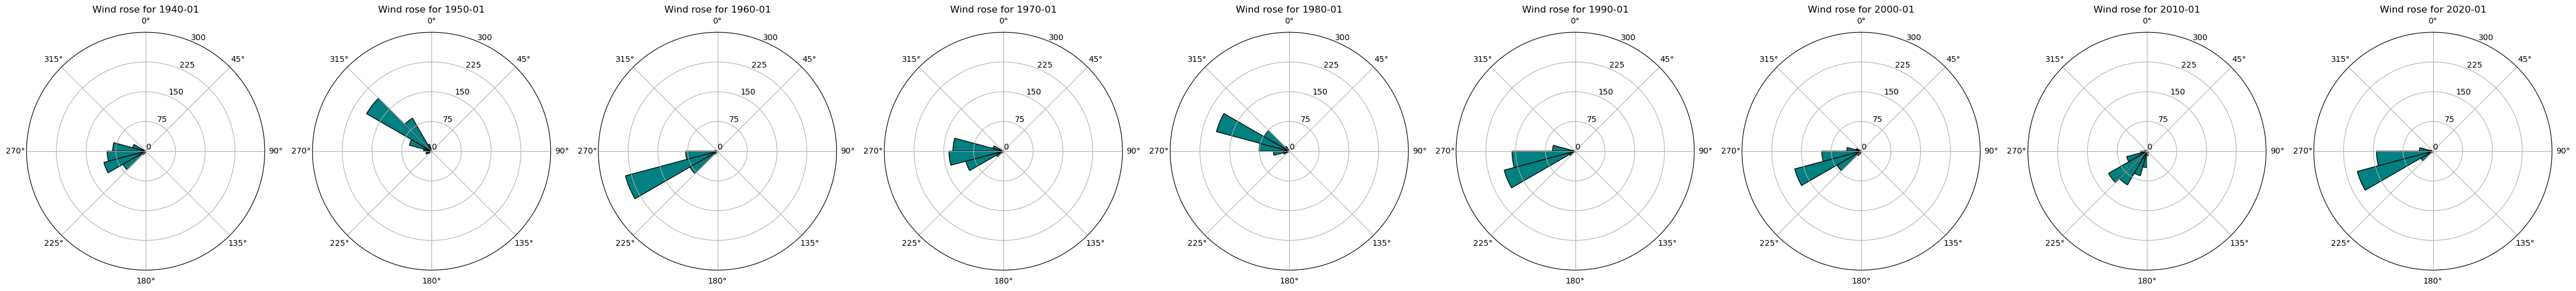

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot wind roses for each year or month-year interval from the input data
def plot_windrose_for_each_interval(excel_file, bin_size=30):

    """
    This script processes wind direction data from an Excel file, bins wind directions into specified intervals (e.g., 30 degrees),
    and generates wind rose plots for each time interval (e.g., yearly or month-year). The radial scale is standardized across all subplots,
    ensuring consistent concentric circles for visual comparison. Each wind rose is titled with the corresponding time interval.

    Parameters:
    - excel_file: Path to the input Excel file containing wind data. Mandatory columns: 'Value' (wind direction in degrees) and 'Year'.
    - bin_size: bin size for the windrose plot (default is 30 degrees).
    """
    try:
        wind_data = pd.read_excel(excel_file, sheet_name="Sheet1")
    except Exception as e:
        raise ValueError(f"Error loading file: {e}")

    if 'Value' not in wind_data.columns or 'Year' not in wind_data.columns:
        raise ValueError("The input file must contain 'Value' and 'Year' columns.")

    if wind_data['Year'].str.contains('_').any():

        wind_data[['Year', 'Month']] = wind_data['Year'].str.split('_', expand=True)
        wind_data['Month'] = wind_data['Month'].astype(int)
        wind_data['Year'] = wind_data['Year'].astype(int)
        wind_data['Year_Month'] = wind_data['Year'].astype(str) + "-" + wind_data['Month'].astype(str).str.zfill(2)

    else:
        wind_data['Year_Month'] = wind_data['Year'].astype(str)  # Default to just year if no month info
    
    bins = np.arange(0, 361, bin_size)
    labels = [f"{i}-{i+bin_size}" for i in bins[:-1]]

    wind_data['Direction Bin'] = pd.cut(wind_data['Value'], bins=bins, labels=labels, include_lowest=True)
    frequency_by_bin = wind_data.groupby(['Year_Month', 'Direction Bin']).size().unstack(fill_value=0)

    if frequency_by_bin.empty:
        raise ValueError("No wind direction data found for the specified time intervals.")  

    num_intervals = len(frequency_by_bin.index)
    if num_intervals == 0:
        raise ValueError("No valid time intervals found in the data.")

    fig, axes = plt.subplots(1, num_intervals, subplot_kw=dict(projection='polar'), figsize=(5 * num_intervals, 5))

    if num_intervals == 1:
        axes = [axes]

    # Shift the angles by half the bin size (to center bins around cardinal directions)
    angles = np.radians(np.arange(0, 360, bin_size)) + np.radians(bin_size / 2)

    manual_rmax = 300

    # Set the constant color to teal
    color_teal = 'teal'

    for i, time_interval in enumerate(frequency_by_bin.index):
        data = frequency_by_bin.loc[time_interval]
        ax = axes[i]

        bars = ax.bar(angles, data, width=np.radians(bin_size), edgecolor='black', color=color_teal)
        ax.set_rmax(manual_rmax) 
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        
        # Modify the title depending on whether it's a single year or month-year
        if '-' in time_interval:
            title = f"Wind rose for {time_interval}"
        else:
            title = f"Wind rose for {time_interval}"
        
        ax.set_title(title)

        radial_ticks = np.linspace(0, manual_rmax, num=5)
        ax.set_rticks(radial_ticks)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

    plt.tight_layout()
    plt.show()

# Example usage
excel_file_path = r'C:\Users\Sunbeam\Desktop\Wind dir_1000mb_1940-2015.xlsx'
plot_windrose_for_each_interval(excel_file_path, bin_size=15)

### Scripts for hourly aggregate

#### Script for masking large nc file with bounding box shp file

In [19]:
import xarray as xr
import geopandas as gpd
from shapely.geometry import mapping
from pathlib import Path
import rioxarray

def subset_nc_with_bbox_shapefile(input_nc_file, bbox_shapefile, pressure_level=1000):
    """
    Clips a NetCDF file using a polygon from a shapefile, identifies valid lat/lon coordinates in 'u' at valid_time=0,
    and uses those coordinates to filter the full dataset across all dimensions, then applies a final mask based on the shapefile.

    Parameters:
    - input_nc_file: Path to the input NetCDF file.
    - bbox_shapefile: Path to the shapefile containing the area of interest as polygons.
    - pressure_level: The pressure level to analyze (default is 1000 mb).

    Output:
    - Saves a single NetCDF file with the subset for the specified lat/lon coordinates within the shapefile extent
      (e.g., "input_filename_filtered.nc").
    """

    input_nc_path = Path(input_nc_file)

    if input_nc_path.exists():
        output_nc_file = input_nc_path.with_name(f"{input_nc_path.stem}_{Path(bbox_shapefile).stem}_masked.nc")
    else:
        raise FileNotFoundError(f"Input NetCDF file not found: {input_nc_file}")

    gdf = gpd.read_file(bbox_shapefile).to_crs("EPSG:4326")
    ds = xr.open_dataset(input_nc_file, chunks=None).sel(pressure_level=pressure_level).isel(valid_time=0)

    if not {'u', 'v'}.issubset(ds.variables):
       raise ValueError("The dataset must contain 'u' and 'v' variables.")

    ds = ds.rio.write_crs("EPSG:4326")
    clipped_ds = ds.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)
    valid_points = clipped_ds['u'].where(~clipped_ds['u'].isnull(), drop=True)

    lat_indices = valid_points.latitude.to_index().values
    lon_indices = valid_points.longitude.to_index().values

    full_ds = xr.open_dataset(input_nc_file, engine='netcdf4')
    ds_filtered = full_ds.sel(latitude=lat_indices, longitude=lon_indices, method="nearest")
    ds_filtered = ds_filtered.rio.write_crs("EPSG:4326")
    ds_final = ds_filtered.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

    ds_final.to_netcdf(output_nc_file)
    print(f"Filtered data saved to {output_nc_file}")

input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper.nc"
# bbox_shapefile = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\BBox\BBox_small.shp"
bbox_shapefile = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\BBox\BBox_large.shp"

subset_nc_with_bbox_shapefile(input_nc_file, bbox_shapefile)

Filtered data saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper_BBox_large_masked.nc


#### Script for generating monthly count of hours per wind direction bins from the masked nc file

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path

def calculate_wind_direction_bins_to_csv(input_nc_file, bin_size=15, cutoff_day=None, aggregation = "yearly"):
    """
    Processes ERA5 wind data to calculate the number of hours the wind falls within specific direction bins for each month.
    Wind direction is calculated in radians, converted to degrees for binning, and saved in a CSV with counts per direction bin.

    Parameters:
    - input_nc_file: Path to the input NetCDF file.
    - bin_size: Wind direction bin size in degrees (default is 15°).
    - cutoff_day: Limits data to days 1 through cutoff_day per month (default is None for full month).
    - aggregation: Defines the type of aggregation (yearly or 5-yearly).
    """

    ds = xr.open_dataset(input_nc_file, engine='netcdf4').squeeze("pressure_level", drop=True)
    times = pd.to_datetime(ds.get("valid_time", ds.get("time")).values)
    if cutoff_day:
        ds, times = ds.sel(valid_time=times.day <= cutoff_day), times[times.day <= cutoff_day]
    
    wind_direction_rad = (np.arctan2(ds['v'], ds['u']) + 2 * np.pi) % (2 * np.pi)
    mean_sin_wd = np.sin(wind_direction_rad).mean(dim=["latitude", "longitude"])
    mean_cos_wd = np.cos(wind_direction_rad).mean(dim=["latitude", "longitude"])

    mean_WD_rad = (np.arctan2(mean_sin_wd, mean_cos_wd) + 2 * np.pi) % (2 * np.pi)
    mean_WD_deg = np.rad2deg(mean_WD_rad)

    df = pd.DataFrame({'year': times.year, 'month': times.month, 'wind_dir': mean_WD_deg}).dropna()
    bins = np.arange(0, 360 + bin_size, bin_size)
    df['wind_dir_bin'] = pd.cut(df['wind_dir'], bins=bins, labels=[f"{int(b)}-{int(b + bin_size)}" for b in bins[:-1]], right=False)
    
    if aggregation == "yearly":
        wind_direction_counts = df.groupby(['year', 'month', 'wind_dir_bin']).size().unstack(fill_value=0)
        output_csv_file = Path(input_nc_file).with_name(f"wind_direction_{bin_size}deg_{aggregation}_{Path(input_nc_file).stem}.csv")
    elif aggregation == "5-yearly":
        df['year'] = df['year'].apply(lambda y: f"{(y // 5) * 5}-{(y // 5) * 5 + 4}")
        wind_direction_counts = df.groupby(['year', 'month', 'wind_dir_bin']).size().unstack(fill_value=0)
        output_csv_file = Path(input_nc_file).with_name(f"wind_direction_{bin_size}deg_{aggregation}_{Path(input_nc_file).stem}.csv")
    else:
        raise ValueError("Invalid aggregation type. Use 'yearly' or '5-yearly'.")

    wind_direction_counts.to_csv(output_csv_file)
    print(f"Wind direction bin counts saved to {output_csv_file}")

# Example usage
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Feb\data_stream-oper_BBox_small_masked.nc"
# input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Feb\data_stream-oper_BBox_large_masked.nc"
calculate_wind_direction_bins_to_csv(input_nc_file, aggregation="5-yearly")


Wind direction bin counts saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Feb\wind_direction_15deg_5-yearly_data_stream-oper_BBox_small_masked.csv


#### Script for generating wind rose charts using csv file

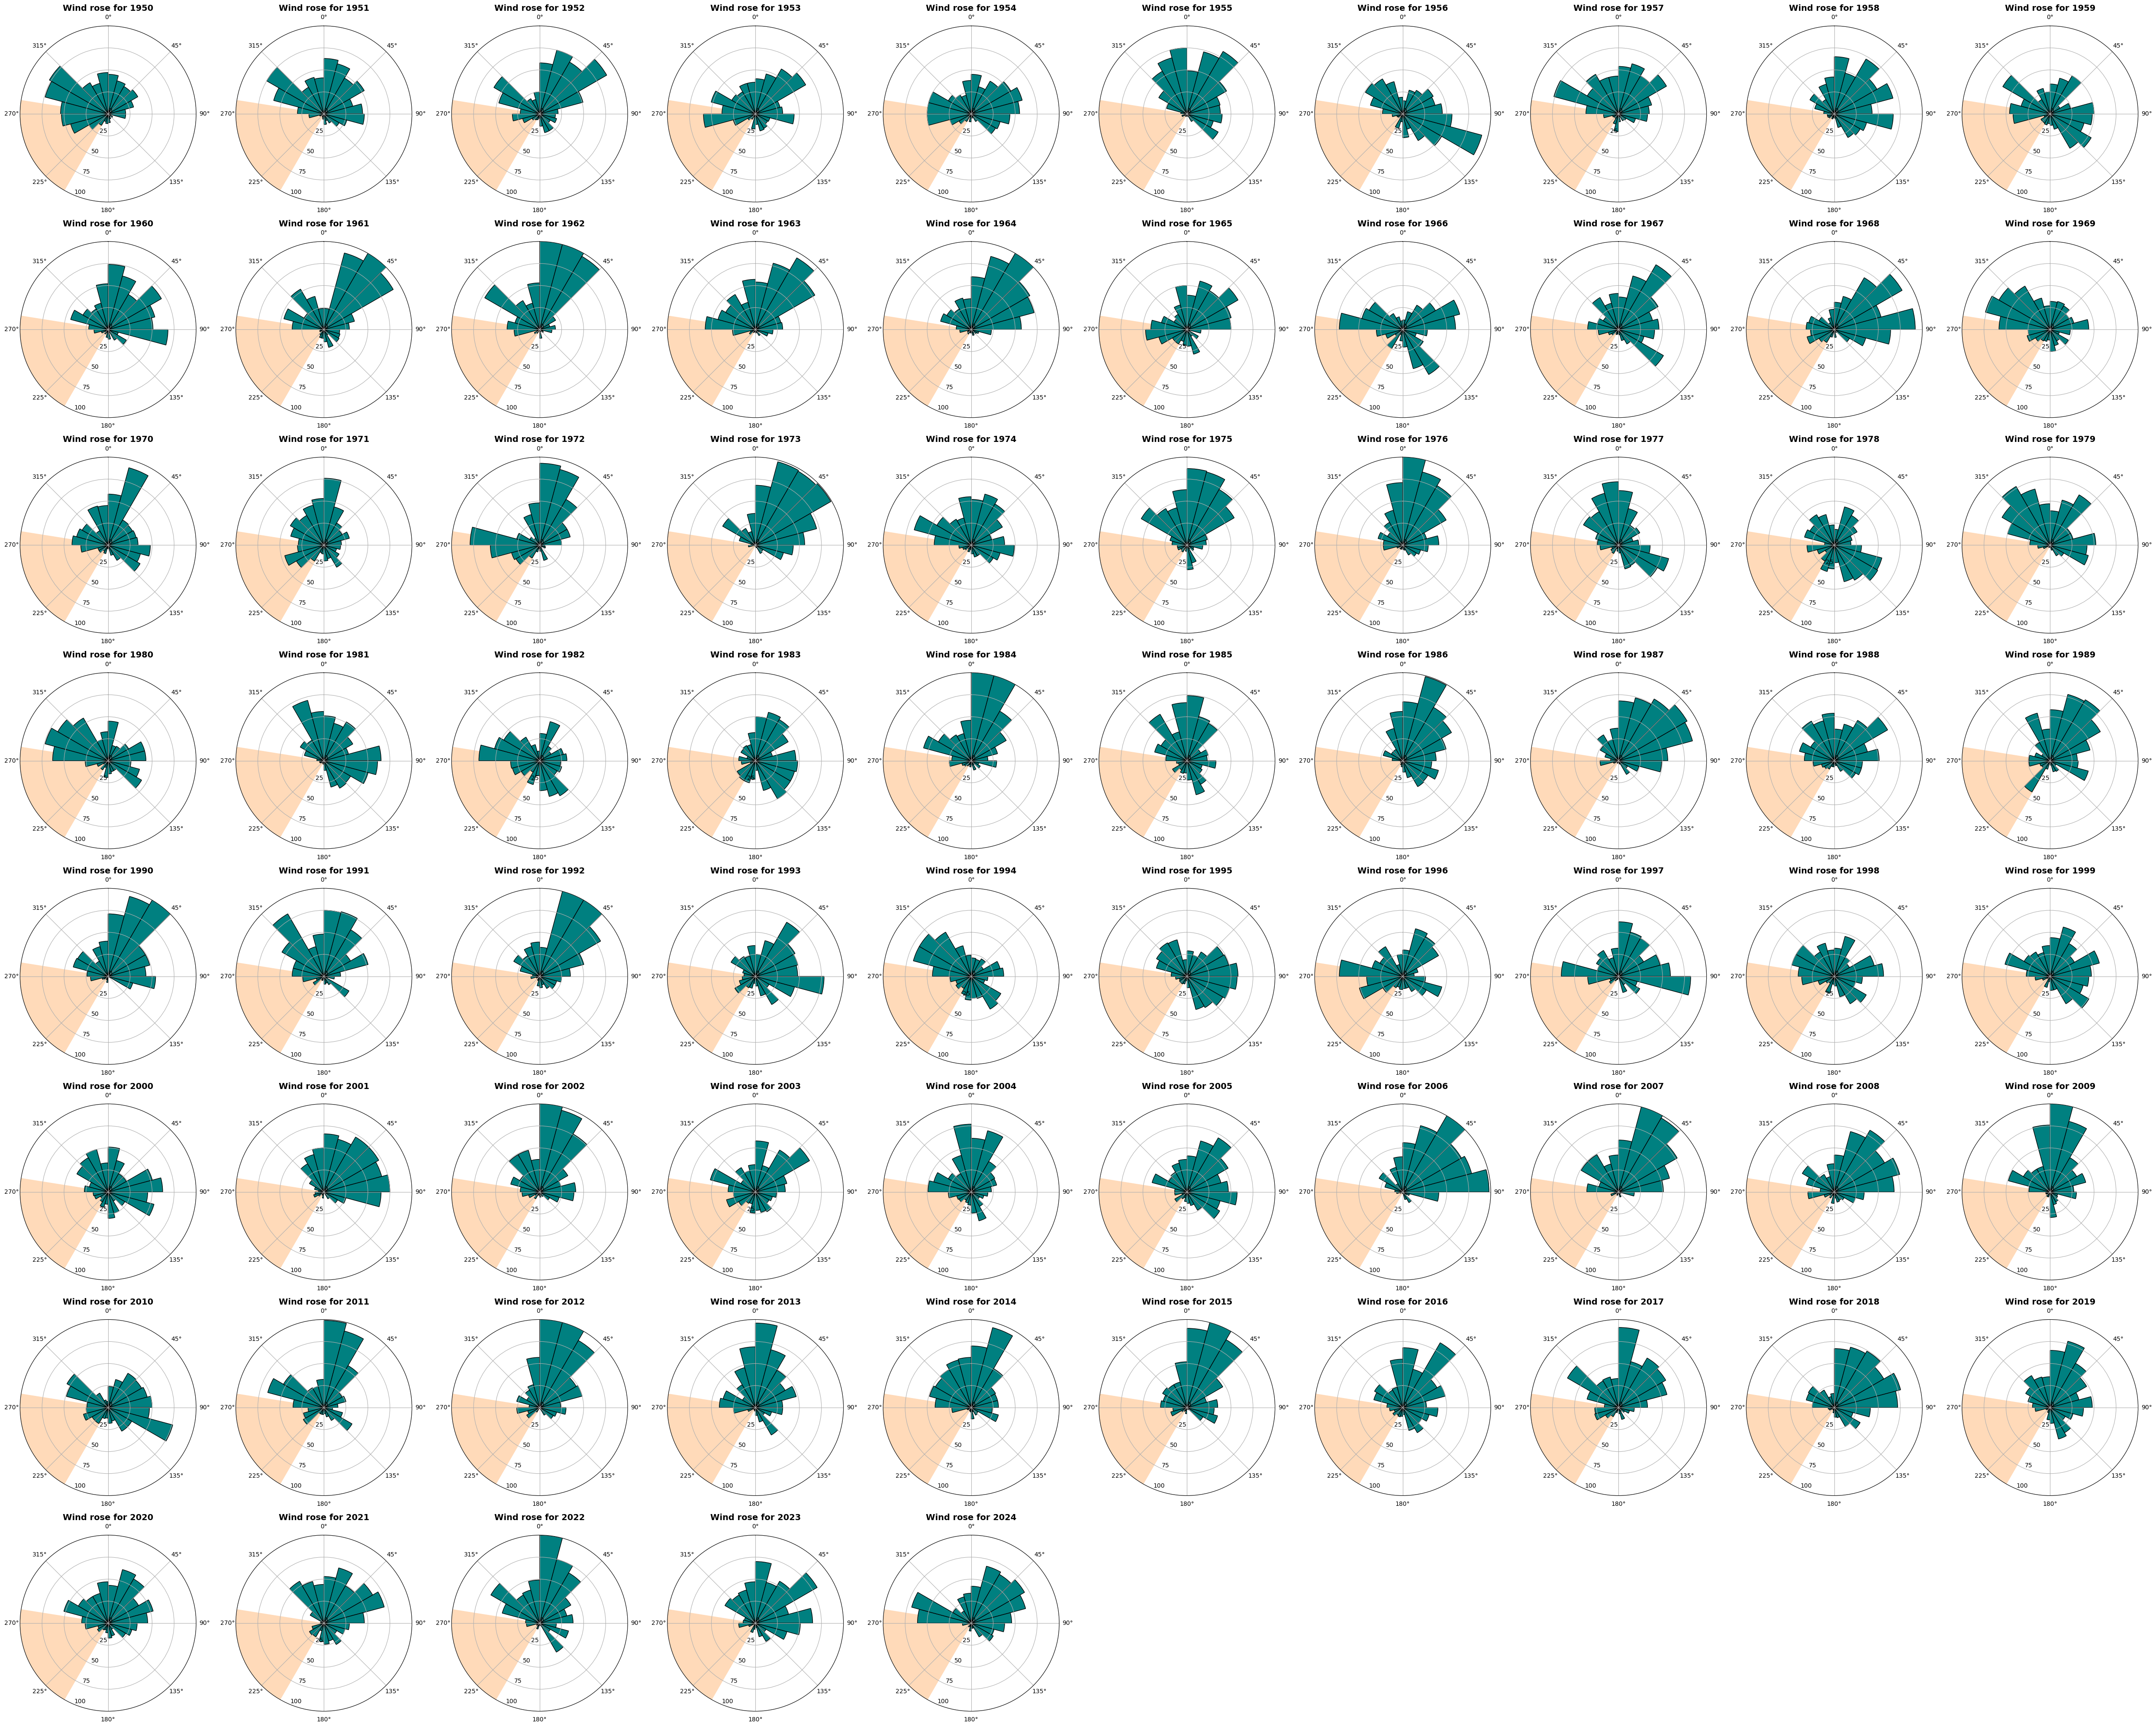

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_windrose_from_csv(csv_file, charts_per_row=10, max_rmax=None):
    """
    Reads wind direction data from a CSV file and generates wind rose plots, arranged by decades (10 charts per row).

    Parameters:
    - csv_file: Path to the input CSV file containing wind direction bin counts.
    - charts_per_row: Number of charts per row (default is 10).
    - max_rmax: The maximum radius for the polar plots (optional). If None, it will auto-scale based on data.
    """
    try:
        # wind_data = pd.read_excel(csv_file, sheet_name="Sheet3")
        wind_data = pd.read_csv(csv_file)
    except Exception as e:
        raise ValueError(f"Error loading CSV file: {e}")

    if 'year' not in wind_data.columns or 'month' not in wind_data.columns:
        raise ValueError("The input CSV must contain 'year' and 'month' columns.")

    direction_bin_columns = wind_data.columns.difference(['year', 'month'])
    frequency_by_bin = wind_data.set_index(['year', 'month'])[direction_bin_columns]

    if frequency_by_bin.empty:
        raise ValueError("No wind direction data found in the CSV file.")

    num_years = len(frequency_by_bin.index.get_level_values('year').unique())
    num_rows = (num_years // charts_per_row) + (1 if num_years % charts_per_row != 0 else 0)

    fig, axes = plt.subplots(num_rows, charts_per_row, subplot_kw=dict(projection='polar'),
                             figsize=(5 * charts_per_row, 5 * num_rows))
    axes = axes.flatten()

    angles = [np.radians((float(b.split('-')[0]) + float(b.split('-')[1])) / 2) for b in direction_bin_columns]
    manual_rmax = frequency_by_bin.values.max() * 1.1 if max_rmax is None else max_rmax

    axis_index = 0

    for index, data in frequency_by_bin.groupby(level=0):
        if index == "1945-1949": continue
        ax = axes[axis_index]
        start_angle, end_angle = np.radians(210), np.radians(279)
        ax.fill_between(np.linspace(start_angle, end_angle, 100), 0, manual_rmax, color='peachpuff')
        data = data.droplevel(0).squeeze()
        ax.bar(angles, data, width=np.radians(15), edgecolor='black', color='teal')
        ax.set_rmax(manual_rmax)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(202.5)
        ax.set_title(f"Wind rose for {index}", fontsize=14, fontweight='bold')
        ax.set_rticks(np.linspace(0, manual_rmax, num=5))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
        axis_index += 1

    for j in range(axis_index, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage
csv_file_path = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\wind_direction_15deg_data_stream-oper_BBox_small_masked.csv"
# csv_file_path = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\wind_direction_15deg_5-yearly_data_stream-oper_BBox_small_calculations.xlsx"
# csv_file_path = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\wind_direction_15deg_5-yearly_data_stream-oper_BBox_large_calculations.xlsx"
plot_windrose_from_csv(csv_file_path, max_rmax=100)


### Script for making web map with wind roses

Successfully added 81 wind roses.



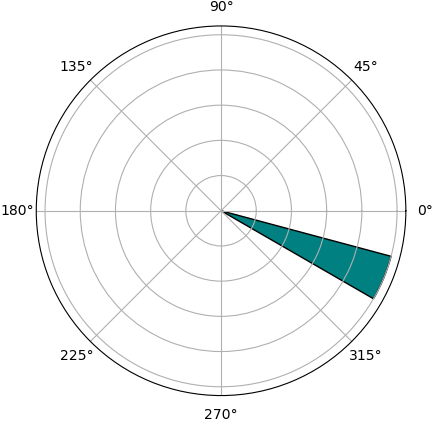
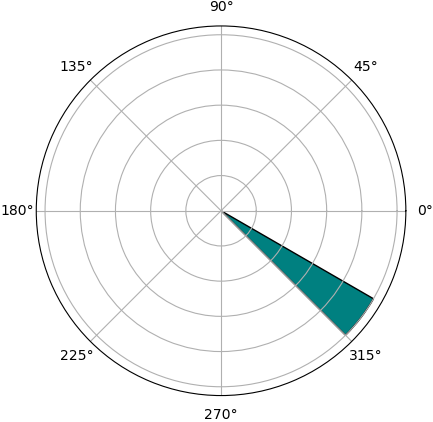
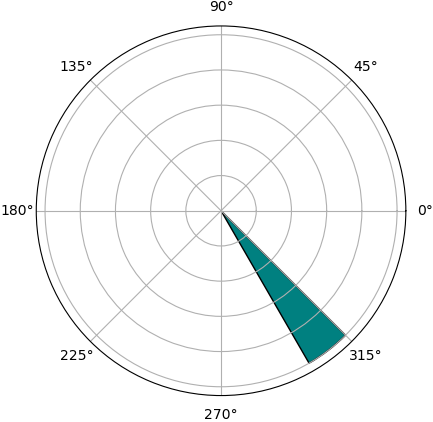
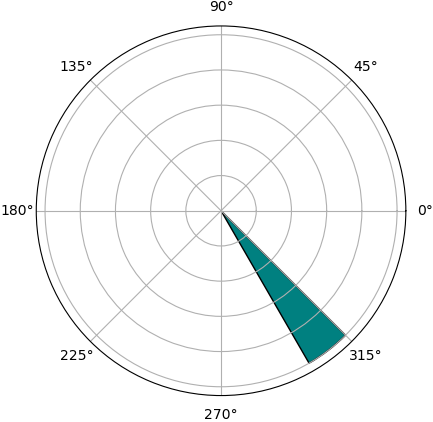
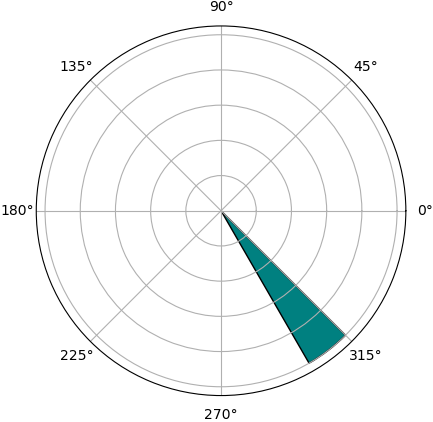
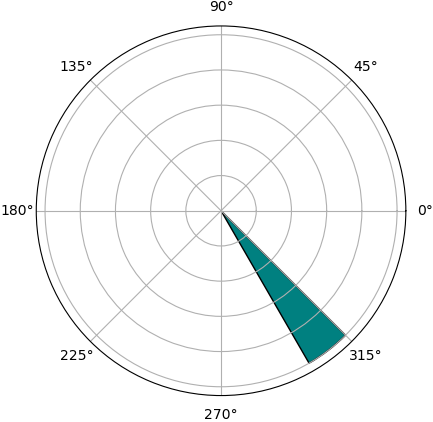
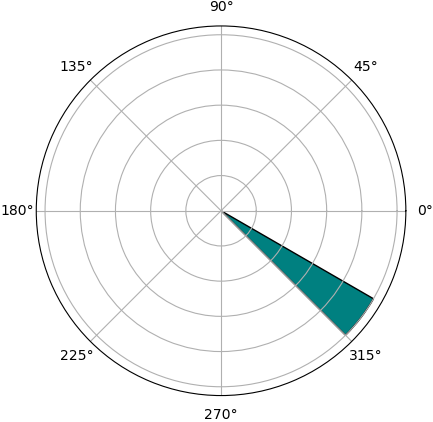
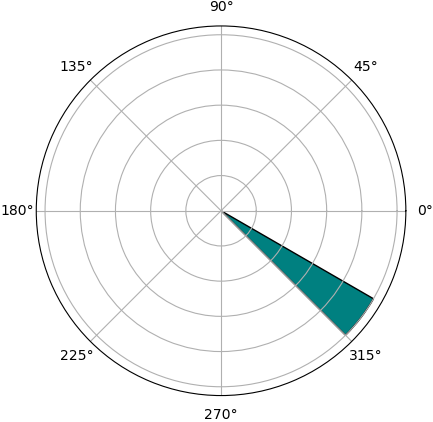
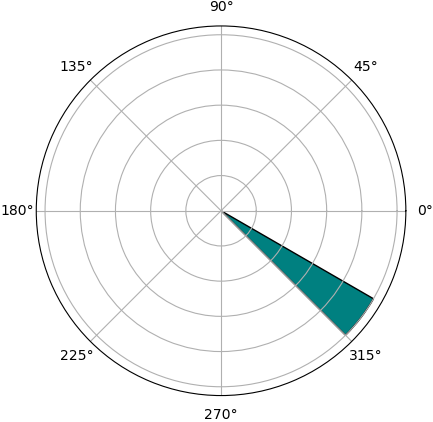
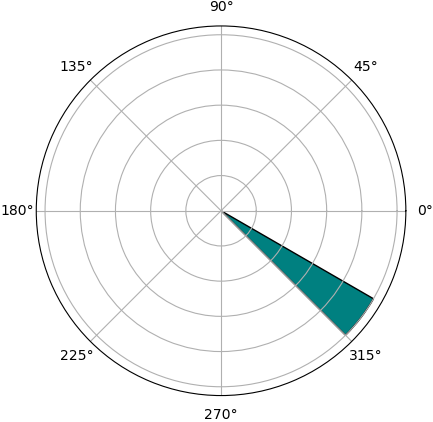
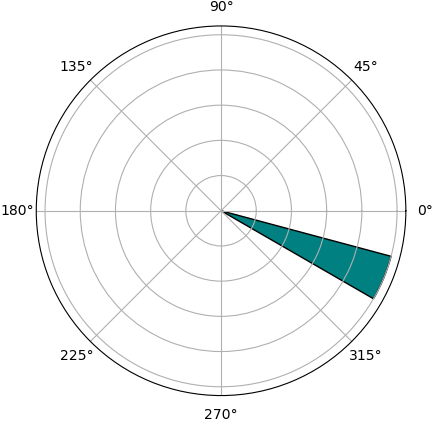
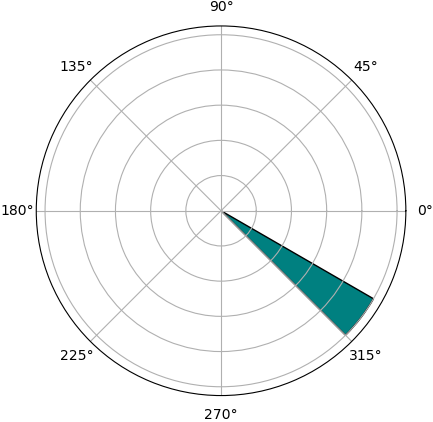
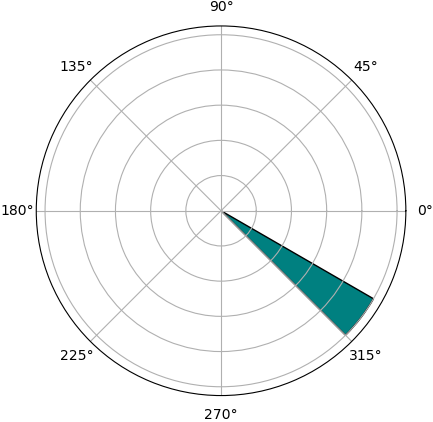
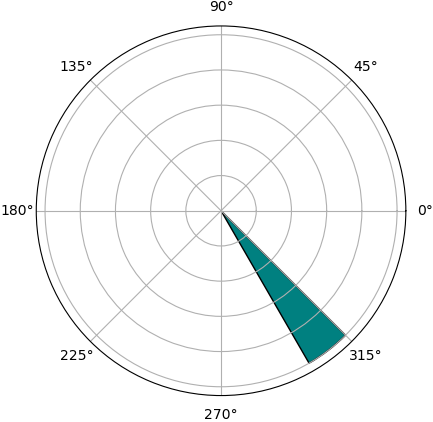
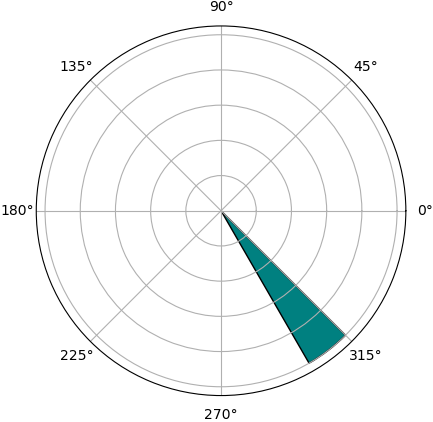
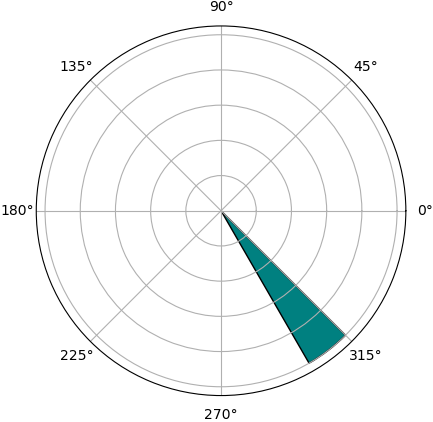
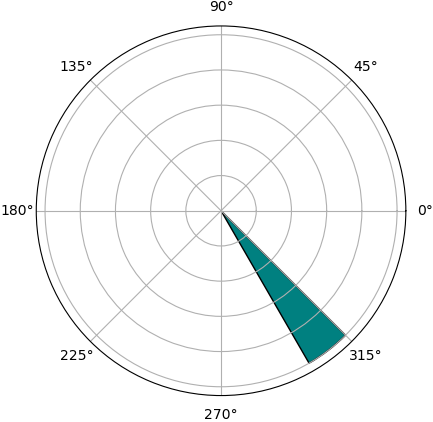
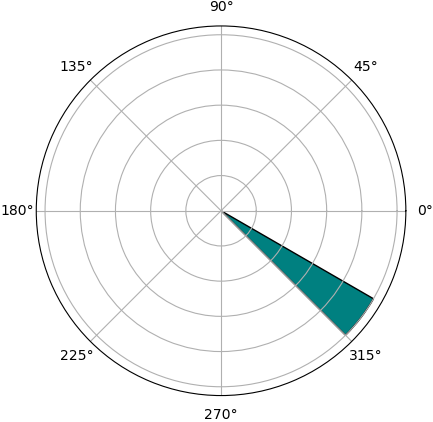
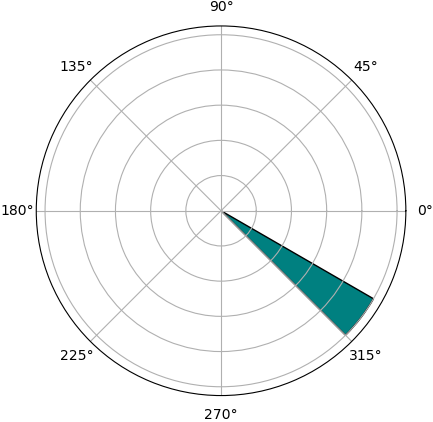
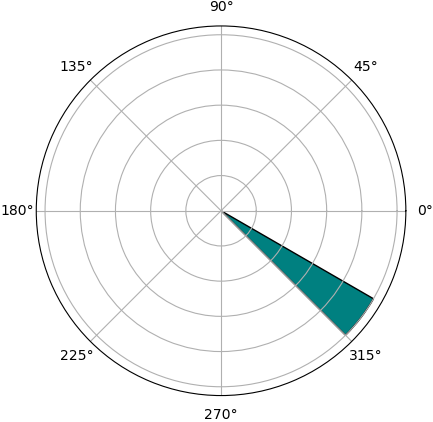
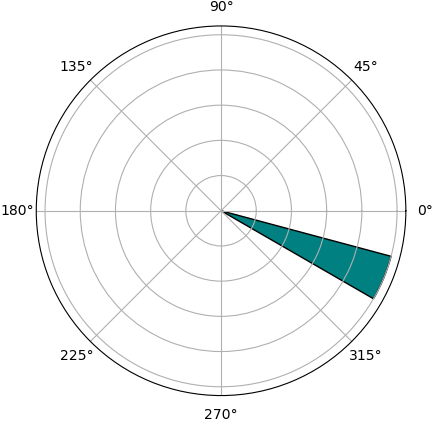
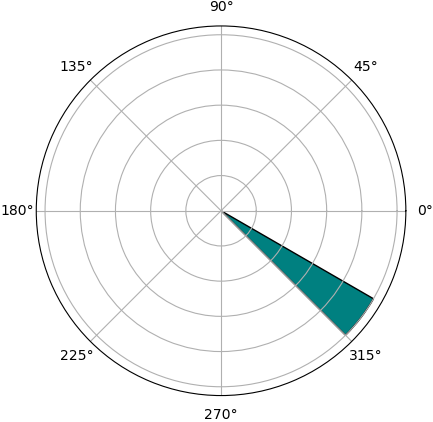
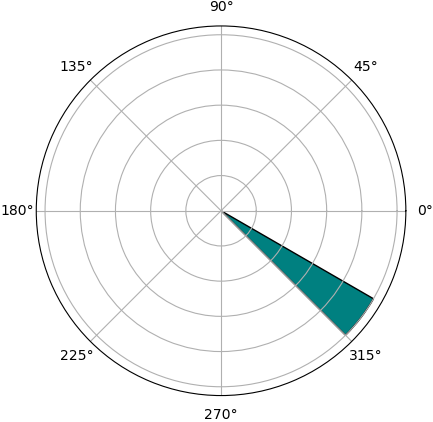
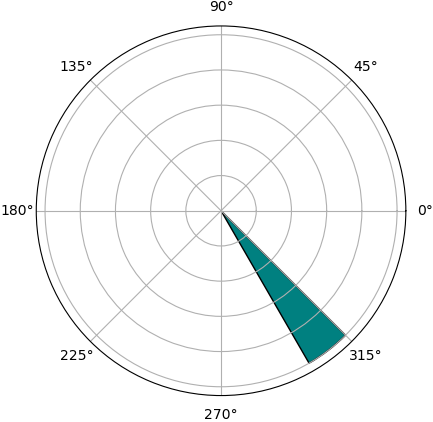
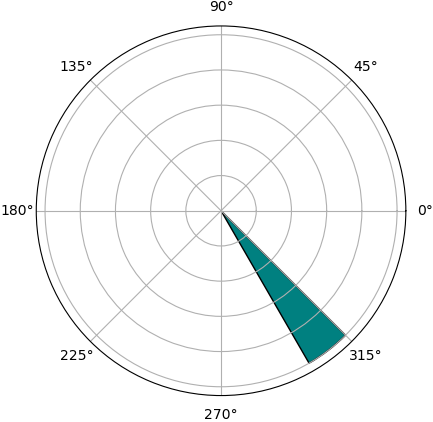
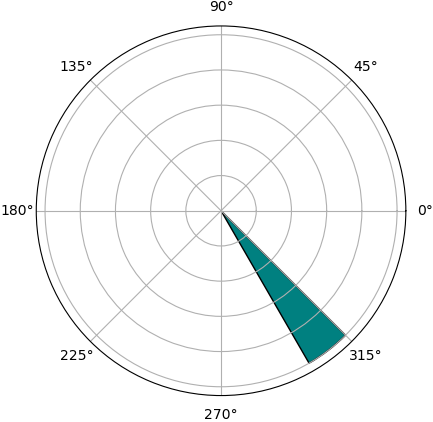
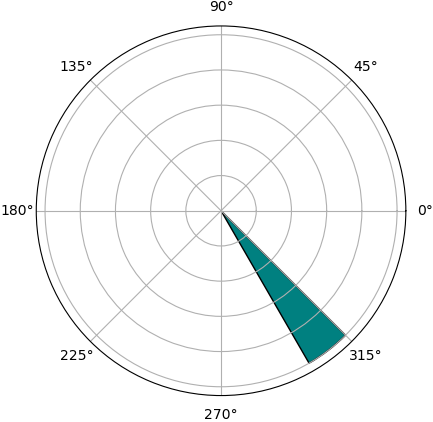
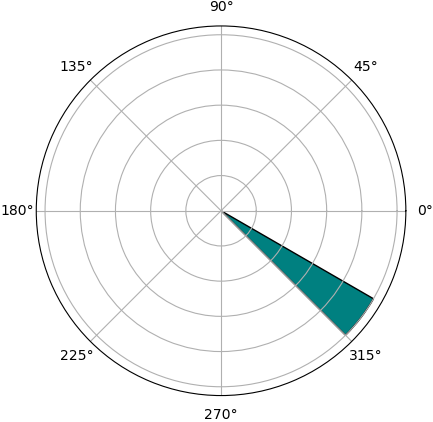
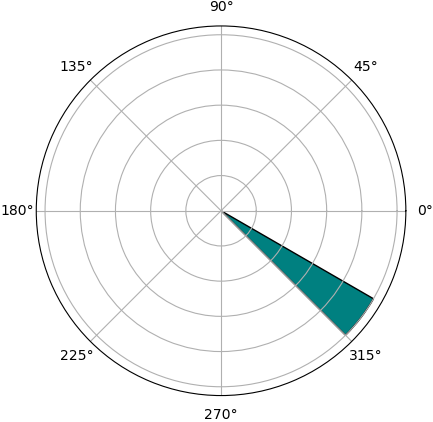
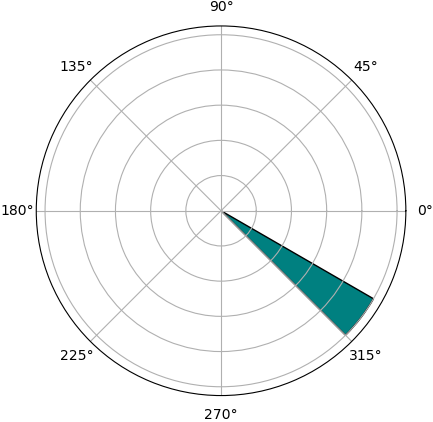
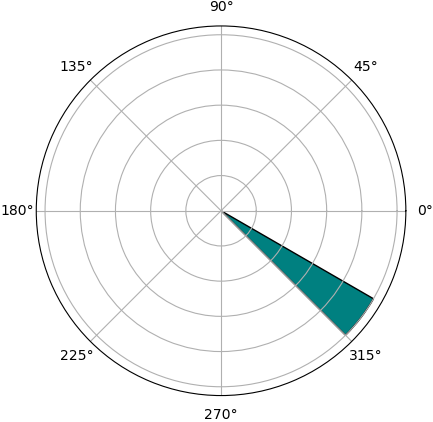
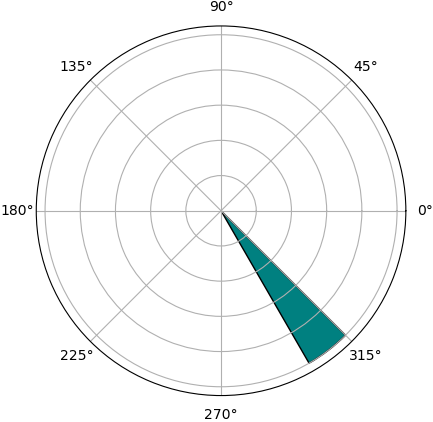
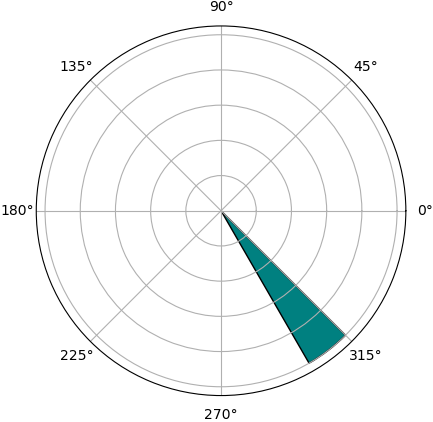
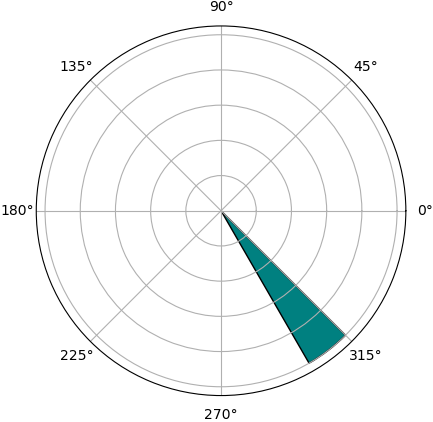
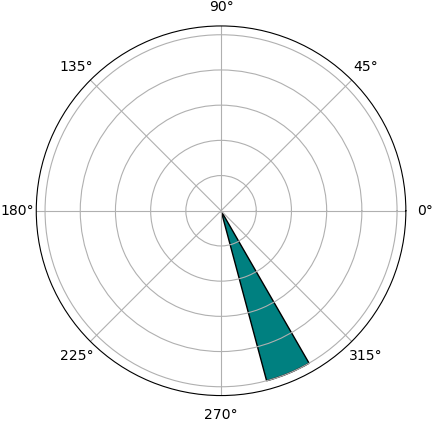
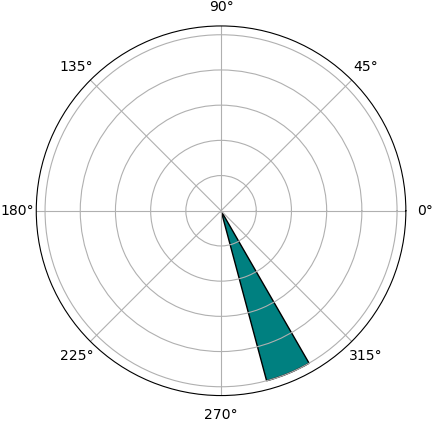
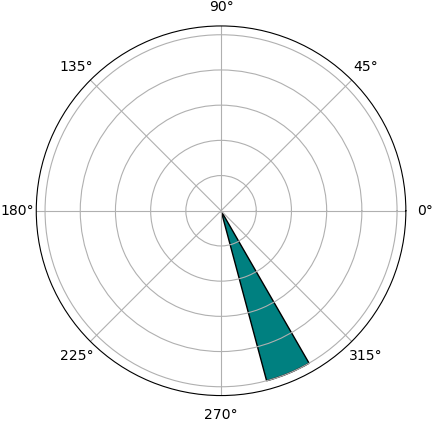
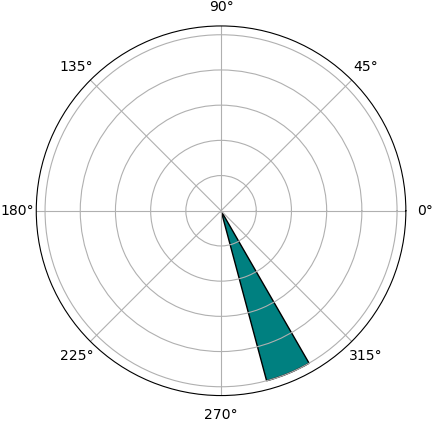
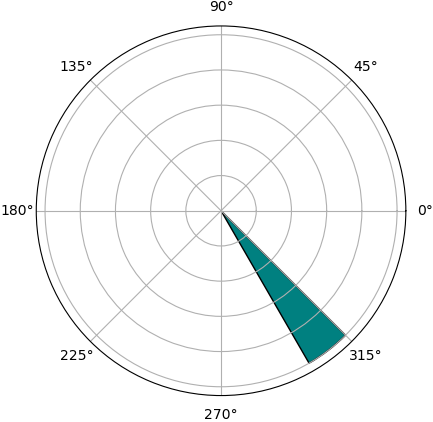
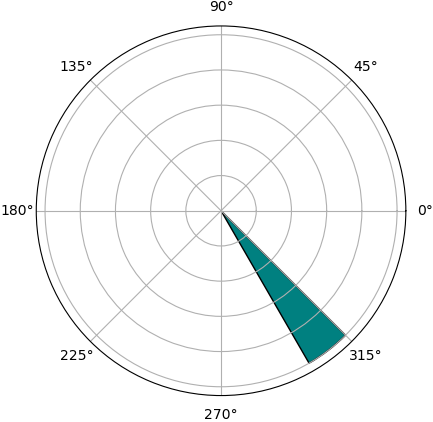
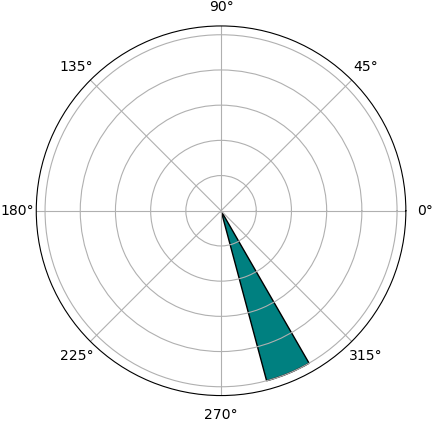
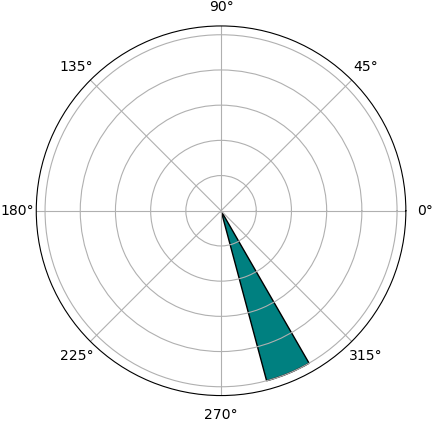
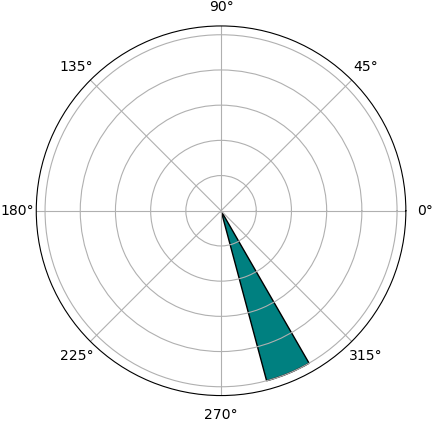
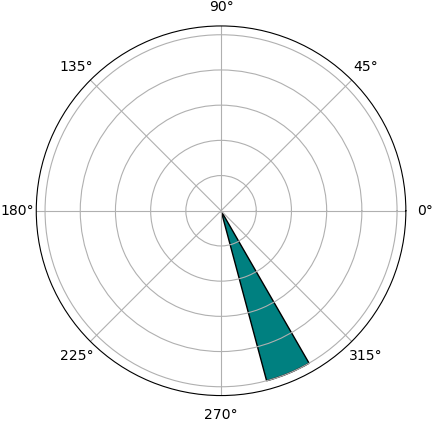
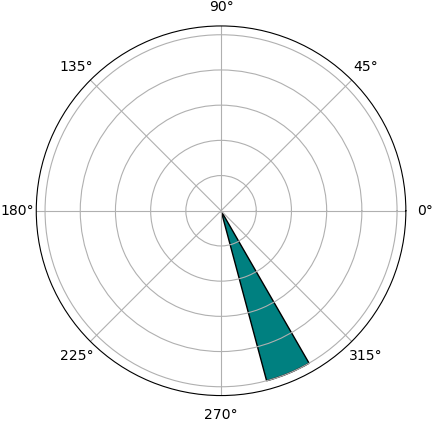
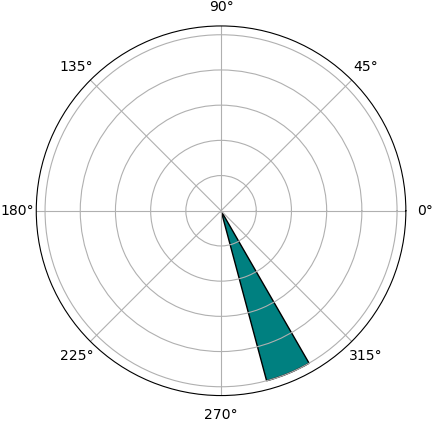
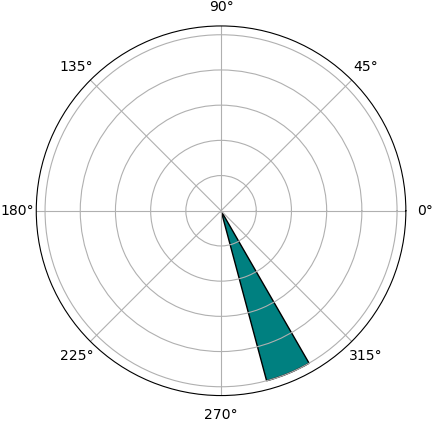
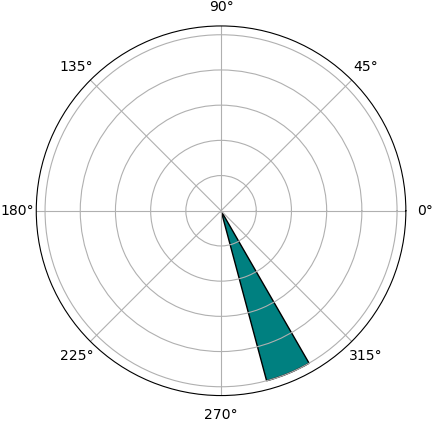
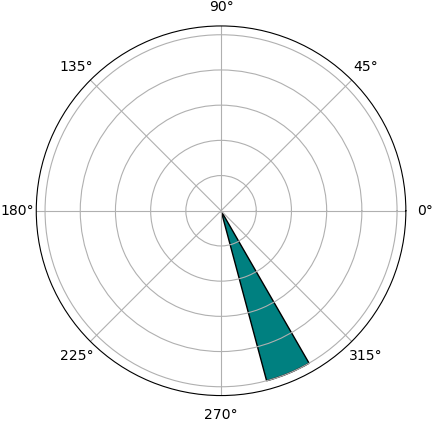
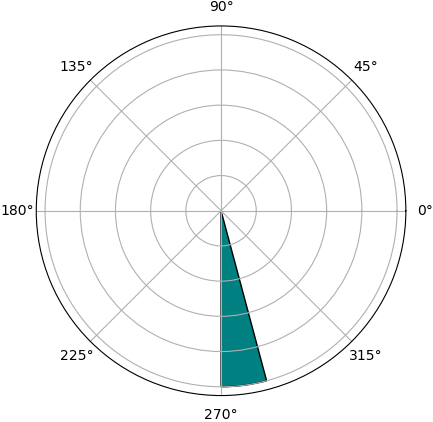
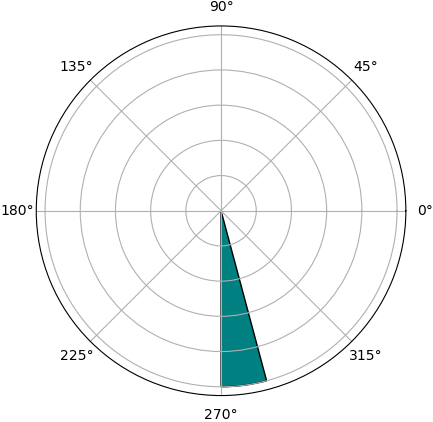
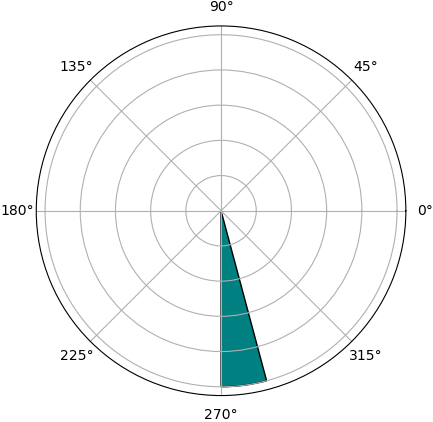
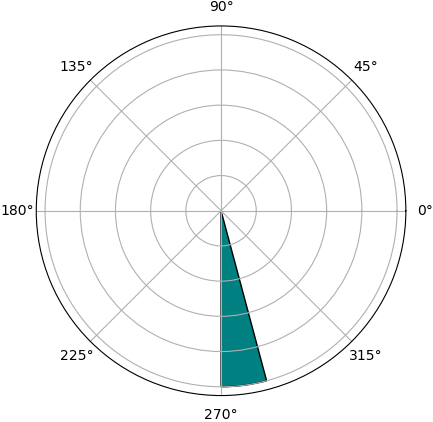
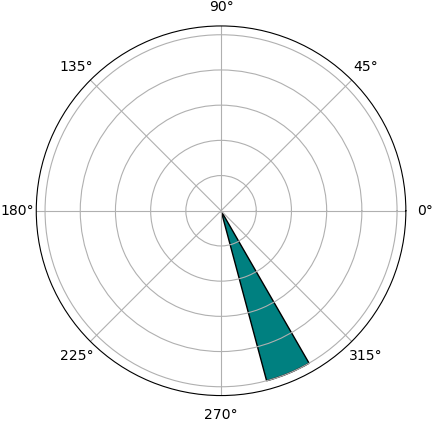
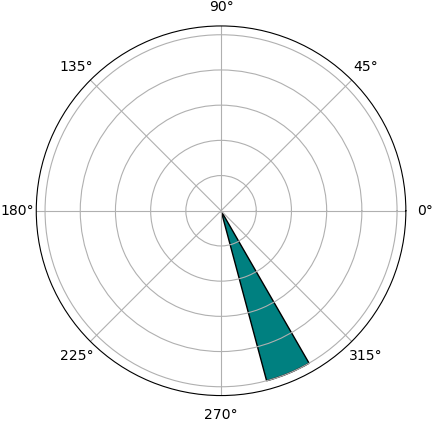
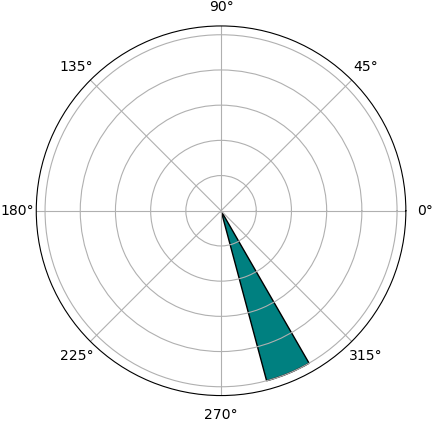
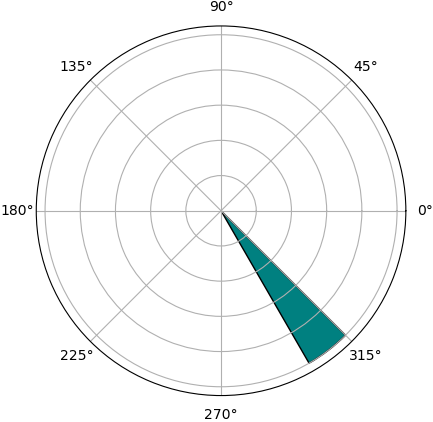
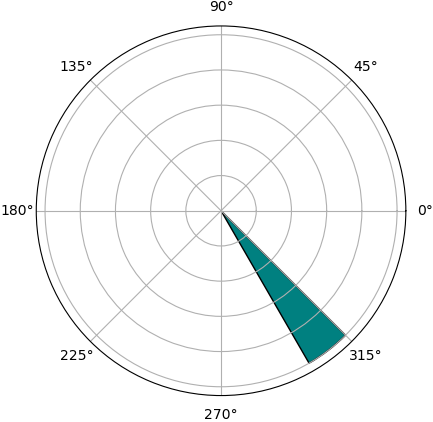
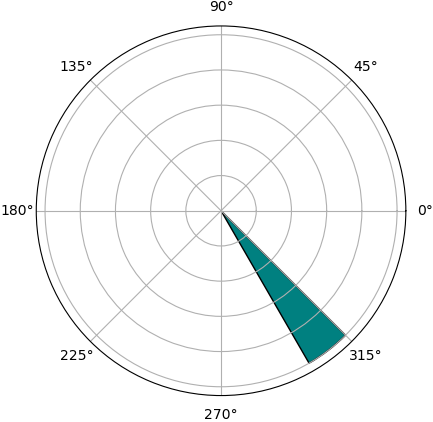
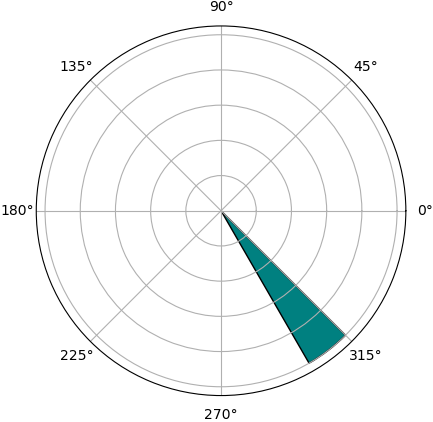
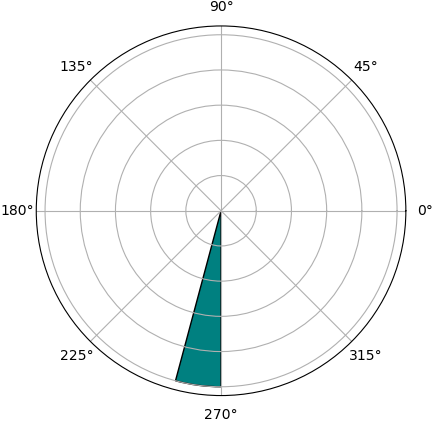
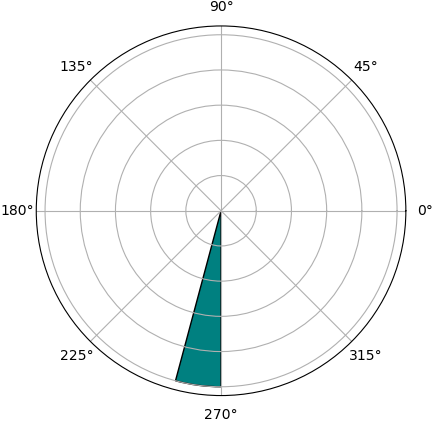
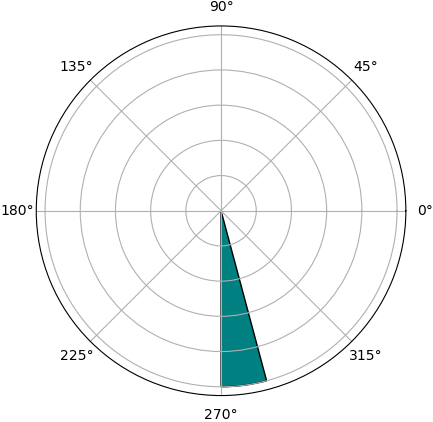
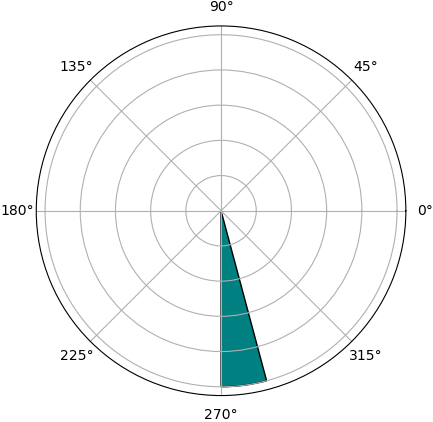
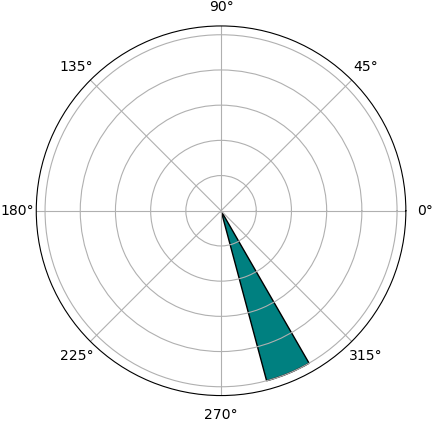
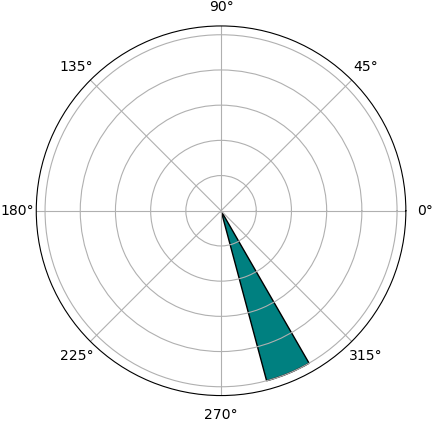
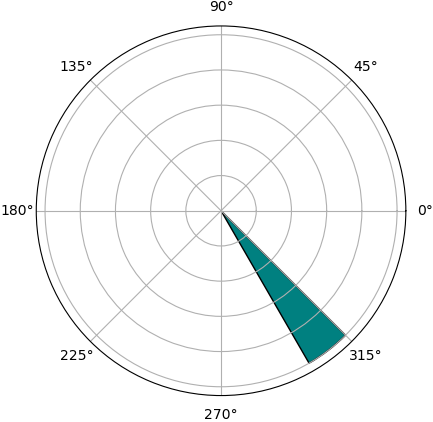
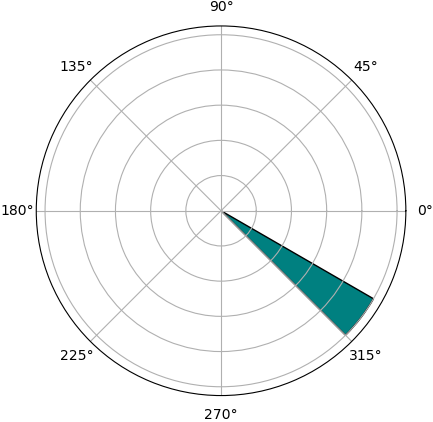
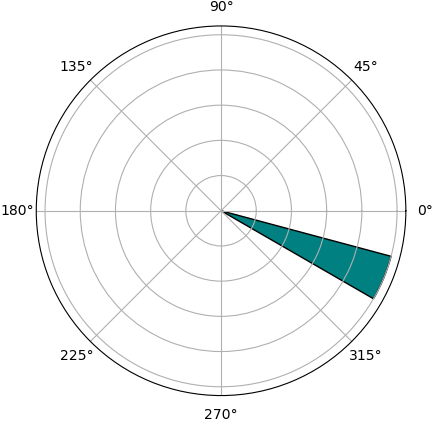
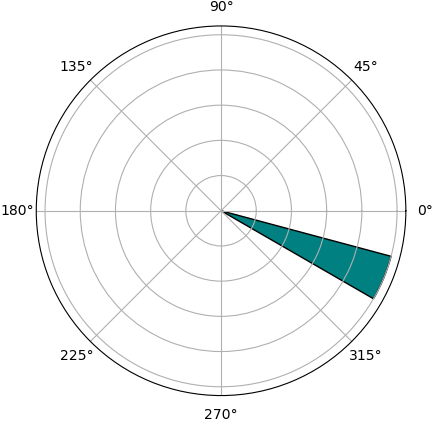
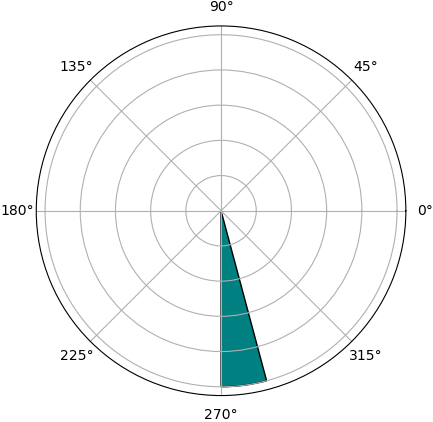
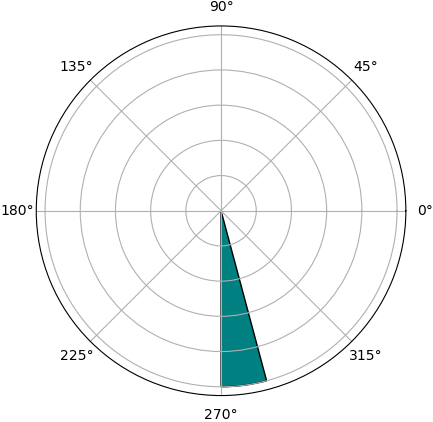
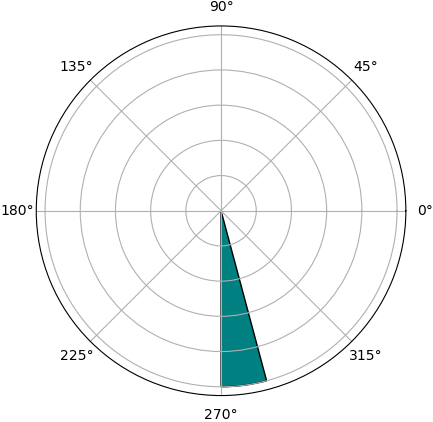
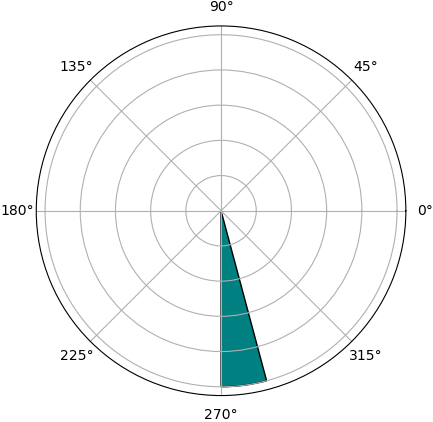
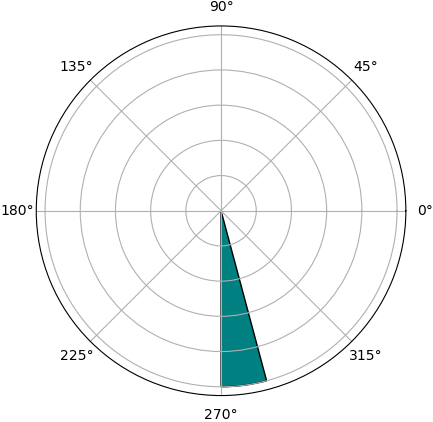
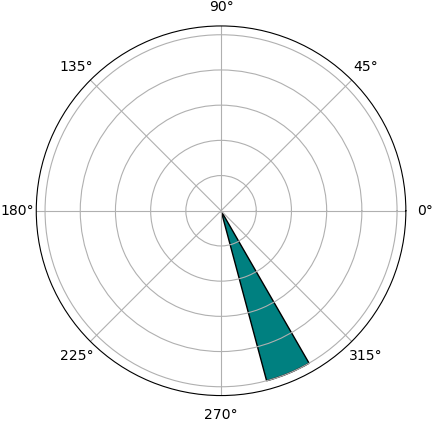
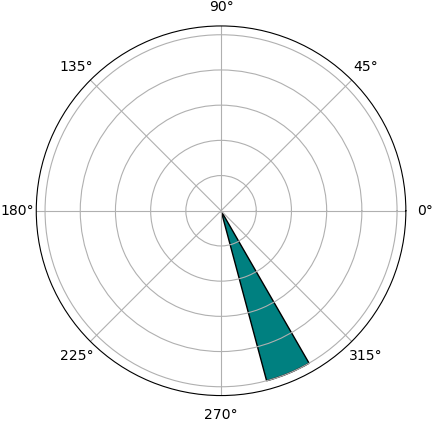
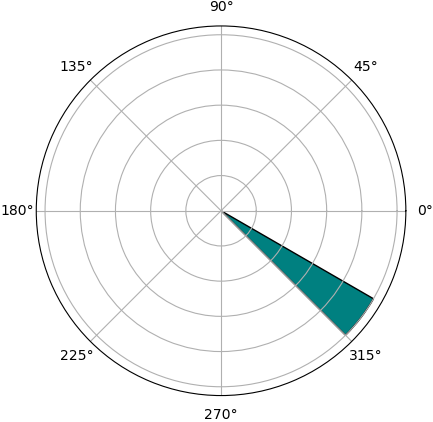
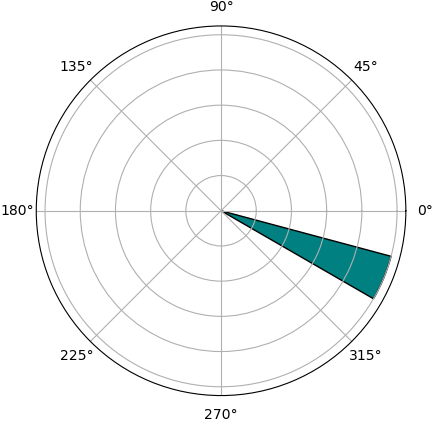
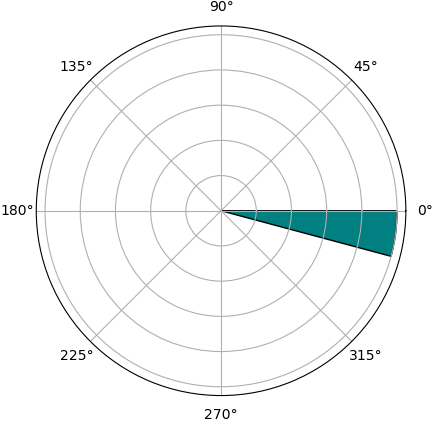

In [ ]:
import folium
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import pandas as pd

# Parameters
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper_BBox_small.nc"
input_datetime = '2024-01-04 00:00:00'
averaging_period = 'hourly'  # Options: 'hourly', 'daily', 'monthly'
center, zoom, max_count = [50.04, -110.68], 9, 100

# Load dataset and select time period for averaging
ds = xr.open_dataset(input_nc_file, engine='netcdf4', chunks={'valid_time': 100})
ds['valid_time'] = pd.to_datetime(ds['valid_time'].values)
sel_time = pd.to_datetime(input_datetime)

if averaging_period == 'hourly':
    ds_sel = ds.sel(valid_time=sel_time, method='nearest')
elif averaging_period == 'daily':
    ds_sel = ds.sel(valid_time=slice(sel_time.normalize(), sel_time.normalize() + pd.Timedelta(days=1))).mean(dim='valid_time', skipna=True)
elif averaging_period == 'monthly':
    start, end = sel_time.replace(day=1), (sel_time.replace(day=1) + pd.DateOffset(months=1)) - pd.Timedelta(days=1)
    ds_sel = ds.sel(valid_time=slice(start, end)).mean(dim='valid_time', skipna=True)
else:
    raise ValueError("Invalid averaging period. Choose from 'hourly', 'daily', 'monthly'.")

# Extract wind components and calculate weighted wind direction
U, V = ds_sel['u'].values, ds_sel['v'].values
lats, lons = ds_sel['latitude'].values, ds_sel['longitude'].values
speed = np.sqrt(U**2 + V**2)
V_east = speed * np.sin(np.arctan2(V, U))
V_north = speed * np.cos(np.arctan2(V, U))
direction = (180 + np.rad2deg(np.arctan2(V_east, V_north))) % 360

# Function to create wind rose plot and return it as a base64 image
def create_wind_rose(direction, speed):
    if np.isnan(direction).all() or np.isnan(speed).all():
        return None
    wind_counts = np.clip(np.bincount(np.digitize(direction, np.arange(0, 361, 15)) - 1, minlength=24), 0, max_count)
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.bar(np.deg2rad(np.arange(0, 360, 15) + 7.5), wind_counts, width=np.deg2rad(15), color='teal', edgecolor='black')
    ax.set_yticklabels([])
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode()

# Create the Folium map
m = folium.Map(location=center, zoom_start=zoom)
for lat_idx, lat in enumerate(lats):
    for lon_idx, lon in enumerate(lons):
        dir_val = direction[lat_idx, lon_idx]
        spd_val = speed[lat_idx, lon_idx]

        if not np.isnan(dir_val) and not np.isnan(spd_val):
            wind_rose_img = create_wind_rose(np.array([dir_val]), np.array([spd_val]))
            if wind_rose_img:
                icon = folium.CustomIcon(f'data:image/png;base64,{wind_rose_img}', icon_size=(60, 60))
                folium.Marker(location=[lat, lon], icon=icon).add_to(m)

print(f"Successfully added {len(m._children)} wind roses.")
m
